# Classifying Emotions from Text

In [1]:
!pip install -q evaluate
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 83.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.2
    Uninstalling transformers-4.53.2:
      Successfully uninstalled transformers-4.53.2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import evaluate
from datasets import Dataset
from sklearn.metrics import confusion_matrix, classification_report


import transformers
from transformers import EarlyStoppingCallback
import evaluate
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaPreTrainedModel, RobertaModel
from transformers import AutoTokenizer, BertForSequenceClassification, BertTokenizer, RobertaTokenizer, RobertaForSequenceClassification
from transformers import TrainingArguments, Trainer
import torch
from tqdm import tqdm

Pull Data

In [3]:
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

df1 = pd.read_csv("data/full_dataset/goemotions_1.csv")
df2 = pd.read_csv("data/full_dataset/goemotions_2.csv")
df3 = pd.read_csv("data/full_dataset/goemotions_3.csv")
emotions = pd.concat([df1, df2, df3], ignore_index = True)
emotions.head()

--2025-07-25 16:17:22--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  62.3MB/s    in 0.2s    

2025-07-25 16:17:22 (62.3 MB/s) - ‘data/full_dataset/goemotions_1.csv’ saved [14174600/14174600]

--2025-07-25 16:17:22--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting r

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


Dataset shape: (211225, 37)
Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')
                                                text       id  \
0                                    That game hurt.  eew5j0j   
1   >sexuality shouldn’t be a grouping category I...  eemcysk   
2     You do right, if you don't care then fuck 'em!  ed2mah1   
3                                 Man I love reddit.  eeibobj   
4  [NAME] was nowhere near them, he was by the Fa...  eda6yn6   

                author            subreddit    link_id   parent_

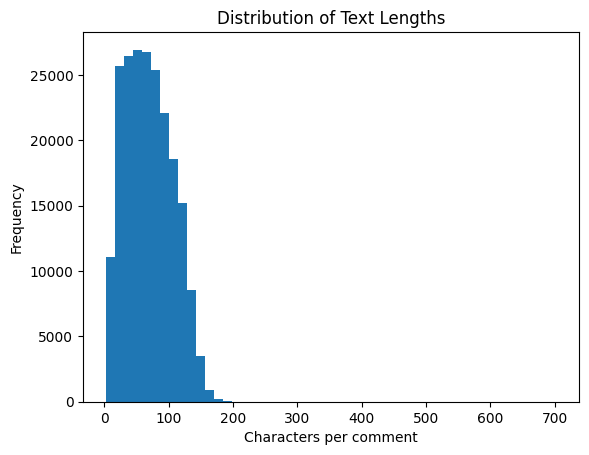

In [4]:
# Check shape and columns
print(f"Dataset shape: {emotions.shape}")
print(emotions.columns)

# Inspect the first few rows
print(emotions.head())

# Check for missing values
print(emotions.isnull().sum())

# Distribution of text lengths (number of tokens or characters)
emotions['text_length'] = emotions['text'].apply(len)
plt.hist(emotions['text_length'], bins=50)
plt.title("Distribution of Text Lengths")
plt.xlabel("Characters per comment")
plt.ylabel("Frequency")
plt.show()

### Data Cleaning
* A text can have more than one row with only one flag for the list of emtion.   
* Making sure we have distinct rows of text where there can be more than one emotion flagged per row
* Removing rows that have no labels

In [5]:
# Columns to drop
drop_cols = ['id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id','example_very_unclear']

# Find columns that exist in the DataFrame
existing_cols_to_drop = [col for col in drop_cols if col in emotions.columns]

emotions.drop(existing_cols_to_drop, axis = 1, inplace = True)

# shape of data
print("SHAPE BEFORE MULTI-LABELS")
print("Shape of Emotions Dataset", emotions.shape)
print("Number of Unique Texts", emotions[['text','text_length']].nunique())

# Grouping by text and aggregated emtion flags
label_cols = emotions.columns.difference(['text','text_length'])
emotions_multi = emotions.groupby('text')[label_cols].max().reset_index()

print("\nSHAPE AFTER MULTI-LABELS")
print("Shape of Emotions Dataset", emotions_multi.shape)
print("Number of Unique Texts", emotions_multi['text'].nunique())

SHAPE BEFORE MULTI-LABELS
Shape of Emotions Dataset (211225, 30)
Number of Unique Texts text           57732
text_length      192
dtype: int64

SHAPE AFTER MULTI-LABELS
Shape of Emotions Dataset (57732, 29)
Number of Unique Texts 57732


In [6]:
emotions_multi.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise
0,"""If you don't wear BROWN AND ORANGE...YOU DON...",0,0,1,1,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,"""What do Scottish people look like?"" How I wo...",0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,"### A surprise, to be sure, but a welcome one",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,"'*Pray*, v. To ask that the laws of the unive...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,">it'll get invaded by tankie, unfortunately. ...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [7]:
# Removing rows that have no labels
emotions_multi = emotions_multi[emotions_multi[label_cols].any(axis=1)]
print("Shape of Emotions Dataset", emotions_multi.shape)

Shape of Emotions Dataset (57730, 29)


### Spliting data into Train, Test, and Validation

* **60% - Train:** Used to train the model and update its weights   
* **20% - Validation:** Used to tune hyperparameters (like learning rate, batch size, epochs) and monitor for overfitting.
* **20% - Test:** Evaluate final model's performance on unseen data after all tuning is done

In [8]:
# Creating relevant columns for labels
# Y value
label_cols = emotions.columns.difference(['text','text_length'])

# Splitting Train, Test, Validation
x_train, x_temp, y_train, y_temp = train_test_split(emotions_multi['text'], emotions_multi[label_cols], test_size = 0.4, random_state = 42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size = 0.5, random_state = 42)

# Combine features and labels into one dataframe for each split
train_emotions = pd.concat([x_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
val_emotions   = pd.concat([x_val.reset_index(drop=True),   y_val.reset_index(drop=True)],   axis=1)
test_emotions  = pd.concat([x_test.reset_index(drop=True),  y_test.reset_index(drop=True)],  axis=1)

# Convert the DataFrames into Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_emotions)
val_dataset = Dataset.from_pandas(val_emotions)
test_dataset = Dataset.from_pandas(test_emotions)


# Creating Baseline Model

Defining sequence length and truncate all records at that length. For records that are shorter than our defined sequence length will add padding characters to insure that input shapes are consistent across all records

In [9]:
from torch.nn import BCEWithLogitsLoss
from transformers import PreTrainedModel

# compute label frequency
label_freq = y_train.sum() / len(y_train)

# compute pos_weight
pos_weight = (1.0 - label_freq) / label_freq
pos_weight_tensor = torch.tensor(pos_weight.values, dtype=torch.float32)

class Multi_Label_With_Weights(nn.Module):
    def __init__(self, base_model: PreTrainedModel, pos_weight: torch.Tensor):
        super().__init__()
        self.base_model = base_model
        self.loss_fn = BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        supported_keys = {"token_type_ids","position_ids","head_mask","inputs_embeds",
            "output_attentions","output_hidden_states","return_dict"}
        filtered_kwargs = {k: v for k, v in kwargs.items() if k in supported_keys}

        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask, **filtered_kwargs)
        logits = outputs.logits

        if labels is not None:
            loss = self.loss_fn(logits, labels.float())
            return {"loss": loss, "logits": logits}
        return {"logits": logits}


In [10]:
MAX_SEQUENCE_LENGTH = 35

In [11]:
label_cols = emotions.columns.difference(['text','text_length'])  # Skip the 'text' and 'text_length' column

# Preprocessing function that accepts both data and tokenizer
def preprocess_emotions(data, tokenizer):
    """
    Function tokenizes text and converts the emotion labels into a list of floats
    """
    encoded = tokenizer.batch_encode_plus(
        data["text"],
        max_length=MAX_SEQUENCE_LENGTH,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
    )

    # Process multi-label binary targets
    encoded["labels"] = [
        [float(data[label][i]) for label in label_cols]
        for i in range(len(data["text"]))
    ]

    return encoded

###########################################################################
# Compute Metric Baseline
def compute_metrics(p):
    predictions, labels = p
    predictions = (predictions > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    subset_accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='micro')
    recall = recall_score(labels, predictions, average='micro')
    f1 = f1_score(labels, predictions, average='micro')

    # Return all the metrics
    return {
        "subset_accuracy": subset_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

###########################################################################

# Function to compute per-epoch metrics for each label
def compute_per_label_metrics(predictions, labels):
    label_metrics = {}
    for idx, label in enumerate(label_cols):
        precision = precision_score(labels[:, idx], predictions[:, idx], zero_division=0)
        recall = recall_score(labels[:, idx], predictions[:, idx], zero_division=0)
        f1 = f1_score(labels[:, idx], predictions[:, idx], zero_division=0)
        label_metrics[label] = {"precision": precision, "recall": recall, "f1": f1}
    return label_metrics


################################################################################
# Compute Metric Fine Tuned
def best_threshold_compute_metrics(p):
    global best_thresholds
    predictions, labels = p

    # Load the best thresholds if they exist
    try:
        best_thresholds = np.load("best_thresholds.npy")
    except FileNotFoundError:
        print("Best thresholds not found. Using default 0.5 thresholds.")
        best_thresholds = None

    # Apply sigmoid if not already applied
    predictions = torch.sigmoid(torch.tensor(predictions)).numpy()

    # Use optimized thresholds if available
    if best_thresholds is not None:
        binary_predictions = np.zeros_like(predictions)
        for i, thresh in enumerate(best_thresholds):
            binary_predictions[:, i] = (predictions[:, i] >= thresh).astype(int)
    else:
        binary_predictions = (predictions >= 0.5).astype(int)

    # Calculate metrics
    subset_accuracy = accuracy_score(labels, binary_predictions)
    precision = precision_score(labels, binary_predictions, average='micro')
    recall = recall_score(labels, binary_predictions, average='micro')
    f1 = f1_score(labels, binary_predictions, average='micro')

    return {
        "subset_accuracy": subset_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


##########################################################################
# Evaluation per Label
def label_evaluation(trainer, preprocessed_dev_data, metrics):

    # Final evaluation on validation set
    final_val_metrics = trainer.evaluate(preprocessed_dev_data)

    print("\nFinal Validation Per-Label Metrics:")
    per_label_metrics = {
        "Label": [],
        "Precision": [],
        "Recall": [],
        "F1": []
    }

    output = trainer.predict(preprocessed_dev_data)
    predictions = output.predictions
    labels = output.label_ids
    predictions = torch.sigmoid(torch.tensor(predictions)).numpy()

    if metrics == compute_metrics:
      binary_predictions = (predictions > 0.5).astype(int)
    else:
      if best_thresholds is not None:
          binary_predictions = np.zeros_like(predictions)
          for i, thresh in enumerate(best_thresholds):
              binary_predictions[:, i] = (predictions[:, i] >= thresh).astype(int)
      else:
          binary_predictions = (predictions >= 0.5).astype(int)

     # Compute metrics per label
    label_metrics = compute_per_label_metrics(binary_predictions, labels)


    for label, metrics in label_metrics.items():
        per_label_metrics["Label"].append(label)
        per_label_metrics["Precision"].append(metrics["precision"])
        per_label_metrics["Recall"].append(metrics["recall"])
        per_label_metrics["F1"].append(metrics["f1"])

    # Create a DataFrame for per-label metrics
    df = pd.DataFrame(per_label_metrics)
    print(df)

    return df


###########################################################################

# Use a wrapper function to pass the tokenizer to the preprocess function
def preprocess_with_tokenizer(batch, tokenizer):
    return preprocess_emotions(batch, tokenizer)

###########################################################################

def fine_tune_classification_model(classification_model,
                                   tokenizer,
                                   train_data,
                                   dev_data,
                                   training_arguments=None,
                                   batch_size=16,
                                   num_epochs=2,
                                   metrics= compute_metrics):
    """
    Preprocess the data using the given tokenizer.
    Create the training arguments and trainer for the given model and data.
    Then train it.
    """
    # Preprocess the data
    preprocessed_train_data = train_data.map(preprocess_with_tokenizer, batched=True, fn_kwargs={'tokenizer': tokenizer})
    preprocessed_dev_data = dev_data.map(preprocess_with_tokenizer, batched=True, fn_kwargs={'tokenizer': tokenizer})

    # Set the training arguments if not provided
    if training_arguments is None:
        training_args = TrainingArguments(
            output_dir="emotions_model",
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=num_epochs,
            eval_strategy="epoch",
            save_strategy="epoch",
            report_to='none'
        )
    else:
        training_args = training_arguments

    # Set up the trainer
    trainer = Trainer(
        model=classification_model,
        args=training_args,
        train_dataset=preprocessed_train_data,
        eval_dataset=preprocessed_dev_data,
        tokenizer=tokenizer,
        compute_metrics=metrics
    )

    # Train the model
    trainer.train()

    label_eval = label_evaluation(trainer, preprocessed_dev_data, metrics)


    return trainer, preprocessed_dev_data, label_eval

###########################################################################


def fine_tune_classif_model_freeze_layers(classification_model,
                                          tokenizer,
                                          train_data,
                                          dev_data,
                                          layers_to_train=["classifier."],
                                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                                          batch_size=16,
                                          num_epochs=2,
                                          metrics=compute_metrics):
    """
    Fine-tune a classification model while freezing all layers except those specified
    in layers_to_train (partial substring match on parameter names).
    """

    # Preprocess the datasets with the tokenizer
    preprocessed_train_data = train_data.map(
        preprocess_with_tokenizer,
        batched=True,
        fn_kwargs={'tokenizer': tokenizer}
    )
    preprocessed_dev_data = dev_data.map(
        preprocess_with_tokenizer,
        batched=True,
        fn_kwargs={'tokenizer': tokenizer}
    )

    # Freeze all layers except those matching substrings in layers_to_train
    for name, param in classification_model.named_parameters():
      if not any(layer_name in name for layer_name in layers_to_train):
        param.requires_grad = False

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="bert_fine_tuned_freeze_emotions",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        eval_strategy="epoch",
        save_strategy="epoch",
        report_to='none'
    )

    # Define Trainer
    trainer = Trainer(
        model=classification_model,
        args=training_args,
        train_dataset=preprocessed_train_data,
        eval_dataset=preprocessed_dev_data,
        compute_metrics=metrics
    )
    # Train the model
    trainer.train()

    label_eval = label_evaluation(trainer, preprocessed_dev_data, metrics)

    return trainer, preprocessed_dev_data, label_eval

###########################################################################


def calc_label_metrics(label, y_true, y_pred, threshold):
    return {
        "label": label,
        "threshold": threshold,
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

def optimize_thresholds_verbose(predictions, labels, label_names):
    threshold_results = {}
    for t in tqdm(range(5, 100, 5), desc="Optimizing thresholds"):
        threshold = t / 100
        y_preds_all = (predictions > threshold).astype(int)
        threshold_results[threshold] = []
        for label_index, label in enumerate(label_names):
            y_true = labels[:, label_index]
            y_pred = y_preds_all[:, label_index]
            threshold_results[threshold].append(
                calc_label_metrics(label, y_true, y_pred, threshold)
            )

    # Find best threshold per label
    best = {label: {"f1": -1, "result": None} for label in label_names}
    for threshold, results in threshold_results.items():
        for result in results:
            label = result["label"]
            if result["f1"] > best[label]["f1"]:
                best[label] = {
                    "f1": result["f1"],
                    "result": result,
                }

    # Create DataFrame
    results = [b["result"] for b in best.values()]
    df = pd.DataFrame(results, index=[r["label"] for r in results])

    # Save best thresholds for future use
    np.save("best_thresholds.npy", df["threshold"].values)

    return df


# Testing the 4 different experiments using DeBERTa

| Experiment # | Name                              | Description                                                        |
|--------------|-----------------------------------|--------------------------------------------------------------------|
| 1            | Simple Baseline                   | Creating a simple model without adding weights, thresholds, or freezing layers. |
| 2            | Threshold Tuning                  | Optimizes thresholds per label for F1.                             |
| 3            | Weighted Loss                     | Adding class weights to handle imbalance.                          |
| 4            | Weighted + Threshold              | Combines class weights and threshold tuning.                       |
| 5            | Weighted + Threshold + Freezing Layers | Adds layer freezing to reduce overfitting and improve generalization. |


# DeBERTa Model

In [12]:
# Define label columns
label_cols = emotions.columns.difference(["text", "text_length"])

# Compute Class Weights
label_frequencies = emotions[label_cols].mean().values
class_weights = 1.0 / (label_frequencies + 1e-5)
class_weights = torch.tensor(class_weights, dtype=torch.float)


In [13]:
# Define Custom DeBERTa Model

from transformers import DebertaV2Model, DebertaV2PreTrainedModel
from torch import nn
import torch

class DebertaForMultiLabelClassification(DebertaV2PreTrainedModel):
    def __init__(self, config, class_weights=None):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.class_weights = class_weights

        self.deberta = DebertaV2Model(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.last_hidden_state[:, 0, :])  # CLS token

        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss(pos_weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits, labels.float())

        return {'loss': loss, 'logits': logits}

#### DeBERTa **before** Weights Applied

In [ ]:
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification
deberta_checkpoint = "microsoft/deberta-v3-base"
deberta_tokenizer = DebertaV2Tokenizer.from_pretrained(deberta_checkpoint)

deberta_model_noWeights = DebertaV2ForSequenceClassification.from_pretrained(
    deberta_checkpoint,
    num_labels=len(label_cols),
    problem_type="multi_label_classification"
)
# Fine-tune model without weights
trainer, preprocessed_val_data, deberta_noWeight_label_eval_val = fine_tune_classification_model(
    deberta_model_noWeights, deberta_tokenizer, train_dataset, val_dataset)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-11-649476782.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.221000,0.211632,0.133033,0.792440,0.285584,0.419857
2,0.200300,0.199813,0.143080,0.788779,0.338158,0.473375



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.760026  0.598344  0.669563
1        amusement   0.859302  0.686165  0.763036
2            anger   0.611717  0.394552  0.479701
3        annoyance   0.540825  0.331516  0.411060
4         approval   0.618433  0.254746  0.360850
5           caring   0.612903  0.215909  0.319328
6        confusion   0.591837  0.334615  0.427518
7        curiosity   0.674863  0.622689  0.647727
8           desire   0.601266  0.169340  0.264256
9   disappointment   0.616071  0.104943  0.179337
10     disapproval   0.600622  0.345465  0.438636
11         disgust   0.615658  0.219543  0.323667
12   embarrassment   0.000000  0.000000  0.000000
13      excitement   0.585616  0.196101  0.293814
14            fear   0.750000  0.330935  0.459235
15       gratitude   0.876847  0.685274  0.769314
16           grief   0.000000  0.000000  0.000000
17             joy   0.642336  0.378984  0.476706
18           

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': deberta_tokenizer}
)

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

deberta_noWeight_label_eval_test = label_evaluation(trainer, preprocessed_test_data, metrics=compute_metrics)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.20178665220737457, 'eval_subset_accuracy': 0.14515849644898665, 'eval_precision': 0.780570460321943, 'eval_recall': 0.33460444283033713, 'eval_f1': 0.4684150319874592, 'eval_runtime': 35.5452, 'eval_samples_per_second': 324.826, 'eval_steps_per_second': 20.312, 'epoch': 2.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.767486  0.620163  0.686004
1        amusement   0.841978  0.684314  0.755003
2            anger   0.601085  0.398740  0.479437
3        annoyance   0.570400  0.347466  0.431859
4         approval   0.598547  0.250095  0.352784
5           caring   0.616883  0.217143  0.321217
6        confusion   0.559748  0.322464  0.409195
7        curiosity   0.716738  0.635948  0.673931
8           desire   0.629139  0.165217  0.261708
9   disappointment   0.561497  0.077605  0.136364
10     disapproval   0.603061  0.347443  0.440880
11         disgust   0.625000  0.203349  0.306859
12   embarrassment   

In [ ]:
# Predict and inspect outputs
predictions_output = trainer.predict(preprocessed_test_data)

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > 0.5).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\n Predictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


 Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['gratitude', 'love']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['neutral', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['sadness']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. How about Israel, or Saudi Arabia? 
Predicted labels: ['curiosity', 'neutral']
Actual labels:    ['approval', 'confusion', 'curiosity', 'neutral']


#### DeBERTa - Creating thresholds

In [ ]:
def calc_label_metrics(label, y_true, y_pred, threshold):
    return {
        "label": label,
        "threshold": threshold,
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

def optimize_thresholds_verbose(predictions, labels, label_names):
    threshold_results = {}
    for t in tqdm(range(5, 100, 5), desc="Optimizing thresholds"):
        threshold = t / 100
        y_preds_all = (predictions > threshold).astype(int)
        threshold_results[threshold] = []
        for label_index, label in enumerate(label_names):
            y_true = labels[:, label_index]
            y_pred = y_preds_all[:, label_index]
            threshold_results[threshold].append(
                calc_label_metrics(label, y_true, y_pred, threshold)
            )

    # Find best threshold per label
    best = {label: {"f1": -1, "result": None} for label in label_names}
    for threshold, results in threshold_results.items():
        for result in results:
            label = result["label"]
            if result["f1"] > best[label]["f1"]:
                best[label] = {
                    "f1": result["f1"],
                    "result": result,
                }

    # Create DataFrame
    results = [b["result"] for b in best.values()]
    df = pd.DataFrame(results, index=[r["label"] for r in results])

    # Save best thresholds for future use
    np.save("best_thresholds.npy", df["threshold"].values)

    return df

deberta_val_output = trainer.predict(preprocessed_val_data)
deberta_logits = deberta_val_output.predictions
deberta_probs = 1 / (1 + np.exp(-deberta_logits))  # sigmoid activation
deberta_true_labels = val_dataset.to_pandas()[label_cols.tolist()].values

threshold_results_df_deberta = optimize_thresholds_verbose(
    predictions=deberta_probs,
    labels=deberta_true_labels,
    label_names=label_cols
)

Optimizing thresholds: 100%|██████████| 19/19 [00:01<00:00, 14.57it/s]


In [ ]:
threshold_results_df_deberta

,label,threshold,f1
admiration,admiration,0.35,0.698323
amusement,amusement,0.45,0.764676
anger,anger,0.25,0.548500
annoyance,annoyance,0.25,0.508812
approval,approval,0.25,0.500234
caring,caring,0.20,0.425826
confusion,confusion,0.25,0.532900
curiosity,curiosity,0.30,0.683352
desire,desire,0.30,0.413793
disappointment,disappointment,0.20,0.420994


### DeBERTa Model With Thresholds Applied

In [ ]:
deberta_checkpoint = "microsoft/deberta-v3-base"
deberta_tokenizer = DebertaV2Tokenizer.from_pretrained(deberta_checkpoint)

# Load model without weights (no pos_weight)
deberta_model_no_weights = DebertaV2ForSequenceClassification.from_pretrained(
    deberta_checkpoint,
    num_labels=len(label_cols),
    problem_type="multi_label_classification"
)

# Fine-tune with threshold-based metrics
trainer_best, preprocessed_val_data, deberta_onlyThresholds_label_eval_val = fine_tune_classification_model(
    deberta_model_no_weights,
    deberta_tokenizer,
    train_dataset,
    val_dataset,
    metrics=best_threshold_compute_metrics  # Uses optimized thresholds
)



Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-11-649476782.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.215600,0.206633,0.073532,0.501338,0.597987,0.545414
2,0.195800,0.198502,0.080461,0.495649,0.647794,0.561600



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.664033  0.739648  0.699804
1        amusement   0.858458  0.692665  0.766701
2            anger   0.484132  0.630053  0.547537
3        annoyance   0.429247  0.629832  0.510544
4         approval   0.424981  0.629081  0.507271
5           caring   0.413103  0.515909  0.458818
6        confusion   0.456006  0.627885  0.528317
7        curiosity   0.618982  0.756303  0.680787
8           desire   0.463203  0.381462  0.418377
9   disappointment   0.343750  0.552091  0.423694
10     disapproval   0.412160  0.659308  0.507230
11         disgust   0.373866  0.522843  0.435979
12   embarrassment   0.172054  0.423077  0.244626
13      excitement   0.392250  0.475917  0.430052
14            fear   0.556522  0.460432  0.503937
15       gratitude   0.848904  0.708373  0.772298
16           grief   0.073009  0.300000  0.117438
17             joy   0.572241  0.433247  0.493137
18           

In [ ]:
# Preprocess test dataset
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': deberta_tokenizer}
)

# Evaluate on test set
test_results = trainer_best.evaluate(preprocessed_test_data)
print(test_results)

# Per-label evaluation using threshold metrics
deberta_onlyThresholds_label_eval_test = label_evaluation(
    trainer_best,
    preprocessed_test_data,
    metrics=best_threshold_compute_metrics
)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.1995808333158493, 'eval_subset_accuracy': 0.07768924302788845, 'eval_precision': 0.49382829984080473, 'eval_recall': 0.64778161128261, 'eval_f1': 0.5604241670485043, 'eval_runtime': 35.8038, 'eval_samples_per_second': 322.48, 'eval_steps_per_second': 20.165, 'epoch': 2.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.670550  0.732688  0.700243
1        amusement   0.830986  0.694118  0.756410
2            anger   0.446920  0.613861  0.517254
3        annoyance   0.448549  0.662768  0.535012
4         approval   0.416539  0.619355  0.498092
5           caring   0.417053  0.514286  0.460594
6        confusion   0.460784  0.638587  0.535308
7        curiosity   0.645513  0.766946  0.701009
8           desire   0.463983  0.380870  0.418338
9   disappointment   0.342224  0.559497  0.424684
10     disapproval   0.416330  0.665491  0.512217
11         disgust   0.378028  0.522727  0.438755
12   embarrassment   0.1

In [ ]:
# Predict and inspect outputs
predictions_output = trainer.predict(preprocessed_test_data)

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > 0.5).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\n Predictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


 Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['gratitude', 'love']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['neutral', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['sadness']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. How about Israel, or Saudi Arabia? 
Predicted labels: ['curiosity', 'neutral']
Actual labels:    ['approval', 'confusion', 'curiosity', 'neutral']


### DeBERTa **with** Weights Applied

In [ ]:
# DeBERTa with Weights Applied
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification
deberta_checkpoint = "microsoft/deberta-v3-base"
deberta_tokenizer = DebertaV2Tokenizer.from_pretrained(deberta_checkpoint)

deberta_withWeights_model = DebertaForMultiLabelClassification.from_pretrained(
    deberta_checkpoint,
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
    class_weights=class_weights
)
# Fine-tune Model with Weights
trainer, preprocessed_val_data, deberta_withWeights_label_eval_val = fine_tune_classification_model(
    deberta_withWeights_model, deberta_tokenizer, train_dataset, val_dataset)

Some weights of DebertaForMultiLabelClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-11-649476782.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,1.450900,1.397496,0.005110,0.252562,0.875361,0.392017
2,1.258700,1.354786,0.010393,0.265505,0.879071,0.407832



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.369651  0.925466  0.528291
1        amusement   0.263824  0.890436  0.407046
2            anger   0.214446  0.926186  0.348257
3        annoyance   0.264590  0.930129  0.411984
4         approval   0.257227  0.962794  0.405987
5           caring   0.172140  0.887500  0.288351
6        confusion   0.225272  0.915385  0.361565
7        curiosity   0.315759  0.915966  0.469625
8           desire   0.132193  0.868093  0.229446
9   disappointment   0.188994  0.937643  0.314581
10     disapproval   0.250952  0.943317  0.396439
11         disgust   0.158568  0.927665  0.270841
12   embarrassment   0.072651  0.892308  0.134363
13      excitement   0.138879  0.920872  0.241359
14            fear   0.137538  0.868106  0.237455
15       gratitude   0.345750  0.920115  0.502629
16           grief   0.049743  0.790909  0.093599
17             joy   0.206705  0.929371  0.338192
18           

In [ ]:
# Evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': deberta_tokenizer}
)

# Evaluate on test set
test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

# Label-level evaluation
deberta_withWeights_label_eval_test = label_evaluation(trainer, preprocessed_test_data, metrics=compute_metrics)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 1.3442596197128296, 'eval_subset_accuracy': 0.008920838385588083, 'eval_precision': 0.2664235917073573, 'eval_recall': 0.8801525331396405, 'eval_f1': 0.40903241232357473, 'eval_runtime': 35.8176, 'eval_samples_per_second': 322.355, 'eval_steps_per_second': 20.158, 'epoch': 2.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.377797  0.911405  0.534169
1        amusement   0.259645  0.903922  0.403413
2            anger   0.204591  0.922592  0.334913
3        annoyance   0.274094  0.950780  0.425518
4         approval   0.261401  0.965844  0.411446
5           caring   0.170325  0.886857  0.285767
6        confusion   0.233486  0.922101  0.372621
7        curiosity   0.334362  0.907845  0.488725
8           desire   0.135276  0.855652  0.233618
9   disappointment   0.193973  0.937177  0.321420
10     disapproval   0.255545  0.948266  0.402596
11         disgust   0.166133  0.930622  0.281935
12   embarrassment  

In [ ]:
# Predict and inspect outputs
predictions_output = trainer.predict(preprocessed_test_data)

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > 0.5).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\n Predictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


 Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'approval', 'confusion', 'curiosity', 'disapproval', 'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride', 'realization', 'relief', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['admiration', 'amusement', 'approval', 'caring', 'desire', 'excitement', 'gratitude', 'joy', 'love', 'optimism', 'realization']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['admiration', 'amusement', 'annoyance', 'approval', 'curiosity', 'excitement', 'joy', 'neutral', 'pride', 'realization', 'relief', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Te

### DeBERTa - Creating Thresholds with Weights

In [ ]:
def calc_label_metrics(label, y_true, y_pred, threshold):
    return {
        "label": label,
        "threshold": threshold,
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

def optimize_thresholds_verbose(predictions, labels, label_names):
    threshold_results = {}
    for t in tqdm(range(5, 100, 5), desc="Optimizing thresholds"):
        threshold = t / 100
        y_preds_all = (predictions > threshold).astype(int)
        threshold_results[threshold] = []
        for label_index, label in enumerate(label_names):
            y_true = labels[:, label_index]
            y_pred = y_preds_all[:, label_index]
            threshold_results[threshold].append(
                calc_label_metrics(label, y_true, y_pred, threshold)
            )

    # Find best threshold per label
    best = {label: {"f1": -1, "result": None} for label in label_names}
    for threshold, results in threshold_results.items():
        for result in results:
            label = result["label"]
            if result["f1"] > best[label]["f1"]:
                best[label] = {
                    "f1": result["f1"],
                    "result": result,
                }

    # Create DataFrame
    results = [b["result"] for b in best.values()]
    df = pd.DataFrame(results, index=[r["label"] for r in results])

    # Save best thresholds for future use
    np.save("best_thresholds.npy", df["threshold"].values)

    return df



deberta_val_output = trainer.predict(preprocessed_val_data)
deberta_logits = deberta_val_output.predictions
deberta_probs = 1 / (1 + np.exp(-deberta_logits))  # sigmoid activation
deberta_true_labels = val_dataset.to_pandas()[label_cols.tolist()].values

threshold_results_df_deberta = optimize_thresholds_verbose(
    predictions=deberta_probs,
    labels=deberta_true_labels,
    label_names=label_cols
)

Optimizing thresholds: 100%|██████████| 19/19 [00:01<00:00, 15.50it/s]


In [ ]:
threshold_results_df_deberta

,label,threshold,f1
admiration,admiration,0.90,0.670095
amusement,amusement,0.95,0.740010
anger,anger,0.90,0.525487
annoyance,annoyance,0.85,0.505121
approval,approval,0.75,0.470397
caring,caring,0.90,0.459033
confusion,confusion,0.90,0.527900
curiosity,curiosity,0.90,0.664708
desire,desire,0.95,0.437451
disappointment,disappointment,0.90,0.421422


### DeBERTa Model with Weights and Thresholds

In [ ]:
# Initialize tokenizer and model checkpoint
deberta_checkpoint = "microsoft/deberta-v3-base"
deberta_tokenizer = DebertaV2Tokenizer.from_pretrained(deberta_checkpoint)

# Initialize model with weights
deberta_withWeights_model = DebertaForMultiLabelClassification.from_pretrained(
    deberta_checkpoint,
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
    class_weights=class_weights
)

# Fine-tune model with threshold-based metrics
trainer, preprocessed_val_data, deberta_weightThreshold_label_eval_val = fine_tune_classification_model(
    deberta_withWeights_model,
    deberta_tokenizer,
    train_dataset,
    val_dataset,
    metrics=best_threshold_compute_metrics
)


Some weights of DebertaForMultiLabelClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-11-649476782.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,1.412700,1.345669,0.049887,0.478579,0.623651,0.541568
2,1.227600,1.349343,0.063745,0.486946,0.659592,0.560271



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.667175  0.679607  0.673333
1        amusement   0.795574  0.701021  0.745311
2            anger   0.436709  0.666960  0.527816
3        annoyance   0.406366  0.651635  0.500571
4         approval   0.370881  0.705011  0.486062
5           caring   0.405360  0.550000  0.466731
6        confusion   0.441288  0.672115  0.532774
7        curiosity   0.575795  0.775630  0.660938
8           desire   0.399142  0.497326  0.442857
9   disappointment   0.375709  0.503422  0.430289
10     disapproval   0.448856  0.573389  0.503537
11         disgust   0.393008  0.470812  0.428406
12   embarrassment   0.274549  0.351282  0.308211
13      excitement   0.316667  0.631881  0.421899
14            fear   0.468451  0.587530  0.521277
15       gratitude   0.834682  0.694899  0.758403
16           grief   0.160714  0.490909  0.242152
17             joy   0.518885  0.496985  0.507699
18           

In [ ]:
# Preprocess test data
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': deberta_tokenizer}
)

# Evaluate on test data
test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

# Per-label evaluation using threshold metrics
deberta_weightThresholds_label_eval_test = label_evaluation(
    trainer,
    preprocessed_test_data,
    metrics=best_threshold_compute_metrics
)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 1.3292449712753296, 'eval_subset_accuracy': 0.06322535943183787, 'eval_precision': 0.48470446482361607, 'eval_recall': 0.6574359905574723, 'eval_f1': 0.5580087080491658, 'eval_runtime': 35.6821, 'eval_samples_per_second': 323.58, 'eval_steps_per_second': 20.234, 'epoch': 2.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.666002  0.680244  0.673048
1        amusement   0.778373  0.712745  0.744115
2            anger   0.400664  0.651665  0.496230
3        annoyance   0.430452  0.701267  0.533457
4         approval   0.368884  0.700949  0.483381
5           caring   0.423240  0.570286  0.485881
6        confusion   0.445509  0.673913  0.536410
7        curiosity   0.602692  0.784463  0.681668
8           desire   0.402332  0.480000  0.437748
9   disappointment   0.375000  0.503326  0.429789
10     disapproval   0.434321  0.577307  0.495709
11         disgust   0.413127  0.511962  0.457265
12   embarrassment   0

In [ ]:
# Predict and inspect outputs
predictions_output = trainer_best.predict(preprocessed_test_data)

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > 0.5).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\n Predictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


 Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'amusement', 'approval', 'confusion', 'curiosity', 'disappointment', 'disapproval', 'excitement', 'gratitude', 'joy', 'optimism', 'pride', 'realization', 'relief', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['admiration', 'approval', 'desire', 'excitement', 'gratitude', 'joy', 'love', 'optimism', 'realization']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['admiration', 'amusement', 'annoyance', 'approval', 'disappointment', 'excitement', 'joy', 'neutral', 'pride', 'realization', 'relief', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization'

### Freezing Layers

In [ ]:
# Initialize tokenizer and model
deberta_checkpoint = "microsoft/deberta-v3-base"
deberta_tokenizer = DebertaV2Tokenizer.from_pretrained(deberta_checkpoint)

deberta_withFreezing_model = DebertaForMultiLabelClassification.from_pretrained(
    deberta_checkpoint,
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
    class_weights=class_weights
)

# Freeze embeddings and first 6 encoder layers
for name, param in deberta_withFreezing_model.named_parameters():
    if name.startswith("deberta.embeddings") or \
       name.startswith("deberta.encoder.layer.0") or \
       name.startswith("deberta.encoder.layer.1") or \
       name.startswith("deberta.encoder.layer.2") or \
       name.startswith("deberta.encoder.layer.3") or \
       name.startswith("deberta.encoder.layer.4") or \
       name.startswith("deberta.encoder.layer.5"):
        param.requires_grad = False

# Fine-tune
trainer, preprocessed_val_data, deberta_weightThresholdFreeze_label_eval_val = fine_tune_classification_model(
    deberta_withFreezing_model,
    deberta_tokenizer,
    train_dataset,
    val_dataset,
    batch_size=16,
    num_epochs=2,
    metrics=best_threshold_compute_metrics
)

Some weights of DebertaForMultiLabelClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-11-649476782.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,1.470300,1.404566,0.053179,0.479621,0.576793,0.523738
2,1.338700,1.354207,0.062792,0.484202,0.608569,0.539308



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.614071  0.614389  0.614230
1        amusement   0.823308  0.610028  0.700800
2            anger   0.423051  0.548330  0.477612
3        annoyance   0.413110  0.599604  0.489185
4         approval   0.337746  0.736143  0.463045
5           caring   0.423945  0.490909  0.454976
6        confusion   0.425631  0.616346  0.503535
7        curiosity   0.602611  0.698319  0.646944
8           desire   0.423818  0.431373  0.427562
9   disappointment   0.352876  0.485171  0.408581
10     disapproval   0.469939  0.457041  0.463400
11         disgust   0.420134  0.397208  0.408350
12   embarrassment   0.289773  0.261538  0.274933
13      excitement   0.300837  0.576835  0.395440
14            fear   0.421371  0.501199  0.457831
15       gratitude   0.860169  0.586141  0.697195
16           grief   0.144068  0.463636  0.219828
17             joy   0.520386  0.417743  0.463450
18           

In [ ]:
# Preprocess the test dataset
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': deberta_tokenizer}
)

# Evaluate the DeBERTa model on the test set
test_results = trainer.evaluate(preprocessed_test_data)
print("\nDeBERTa Test Set Evaluation Results:")
print(test_results)

# Compute detailed per-label evaluation using your label_evaluation function
deberta_weightThresholdFreeze_label_eval_test = label_evaluation(
    trainer,
    preprocessed_test_data,
    metrics=best_threshold_compute_metrics
)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]


DeBERTa Test Set Evaluation Results:
{'eval_loss': 1.3481714725494385, 'eval_subset_accuracy': 0.060194006582366184, 'eval_precision': 0.4837204828548069, 'eval_recall': 0.6088009200411597, 'eval_f1': 0.5391006056707938, 'eval_runtime': 35.0829, 'eval_samples_per_second': 329.106, 'eval_steps_per_second': 20.58, 'epoch': 2.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.621251  0.622200  0.621725
1        amusement   0.791667  0.614706  0.692053
2            anger   0.410176  0.587759  0.483167
3        annoyance   0.431603  0.644250  0.516911
4         approval   0.338650  0.733207  0.463309
5           caring   0.451000  0.515429  0.481067
6        confusion   0.437061  0.619565  0.512552
7        curiosity   0.634282  0.696116  0.663762
8           desire   0.402852  0.393043  0.397887
9   disappointment   0.350455  0.484109  0.406580
10     disapproval   0.472042  0.471487  0.471765
11         disgust   0.428941  0.3

In [ ]:
# Load best thresholds and predict on validation data with readable output

best_thresholds = np.load("best_thresholds.npy")

predictions_output = trainer.predict(preprocessed_val_data)
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))  # Sigmoid to get probabilities

predicted_labels = (probs > best_thresholds).astype(int)

texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\nPredictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")



Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['caring', 'fear', 'nervousness', 'neutral']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['approval', 'neutral']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['approval', 'excitement', 'joy']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['gratitude', 'realization']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. How about Israel, or Saudi Arabia? 
Predicted labels: ['annoyance', 'approval', 'disappointment', 'disapproval', 'neutral', 'rea

### Creating confusion matrix from best model: Weights, Thresholds

In [ ]:
# Predict
predictions_output = trainer_best.predict(preprocessed_test_data)
logits = predictions_output.predictions
labels = predictions_output.label_ids

# Convert logits to probabilities using sigmoid
probs = torch.sigmoid(torch.tensor(logits)).numpy()

try:
    best_thresholds = np.load("best_thresholds.npy")
    preds = (probs > best_thresholds).astype(int)
except FileNotFoundError:
    print("Best thresholds not found. Using default threshold of 0.5.")
    preds = (probs > 0.5).astype(int)

rows = []
for i in range(preds.shape[1]):
    cm = confusion_matrix(labels[:, i], preds[:, i])
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    rows.append({
        'Label': label_cols[i],  # <-- Use your custom label names
        'True Negative': tn,
        'False Positive': fp,
        'False Negative': fn,
        'True Positive': tp,
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'F1 Score': round(f1, 3)
    })

# Display the final confusion matrix summary
confusion_summary_df = pd.DataFrame(rows)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(confusion_summary_df)

             Label  True Negative  False Positive  False Negative  True Positive  Precision  Recall  F1 Score
0       admiration           8875             707             525           1439      0.671   0.733     0.700
1        amusement          10382             144             312            708      0.831   0.694     0.756
2            anger           9591             844             429            682      0.447   0.614     0.517
3        annoyance           7822            1672             692           1360      0.449   0.663     0.535
4         approval           6625            2286            1003           1632      0.417   0.619     0.498
5           caring          10042             629             425            450      0.417   0.514     0.461
6        confusion           9617             825             399            705      0.461   0.639     0.535
7        curiosity           9680             553             306           1007      0.646   0.767     0.701
8         

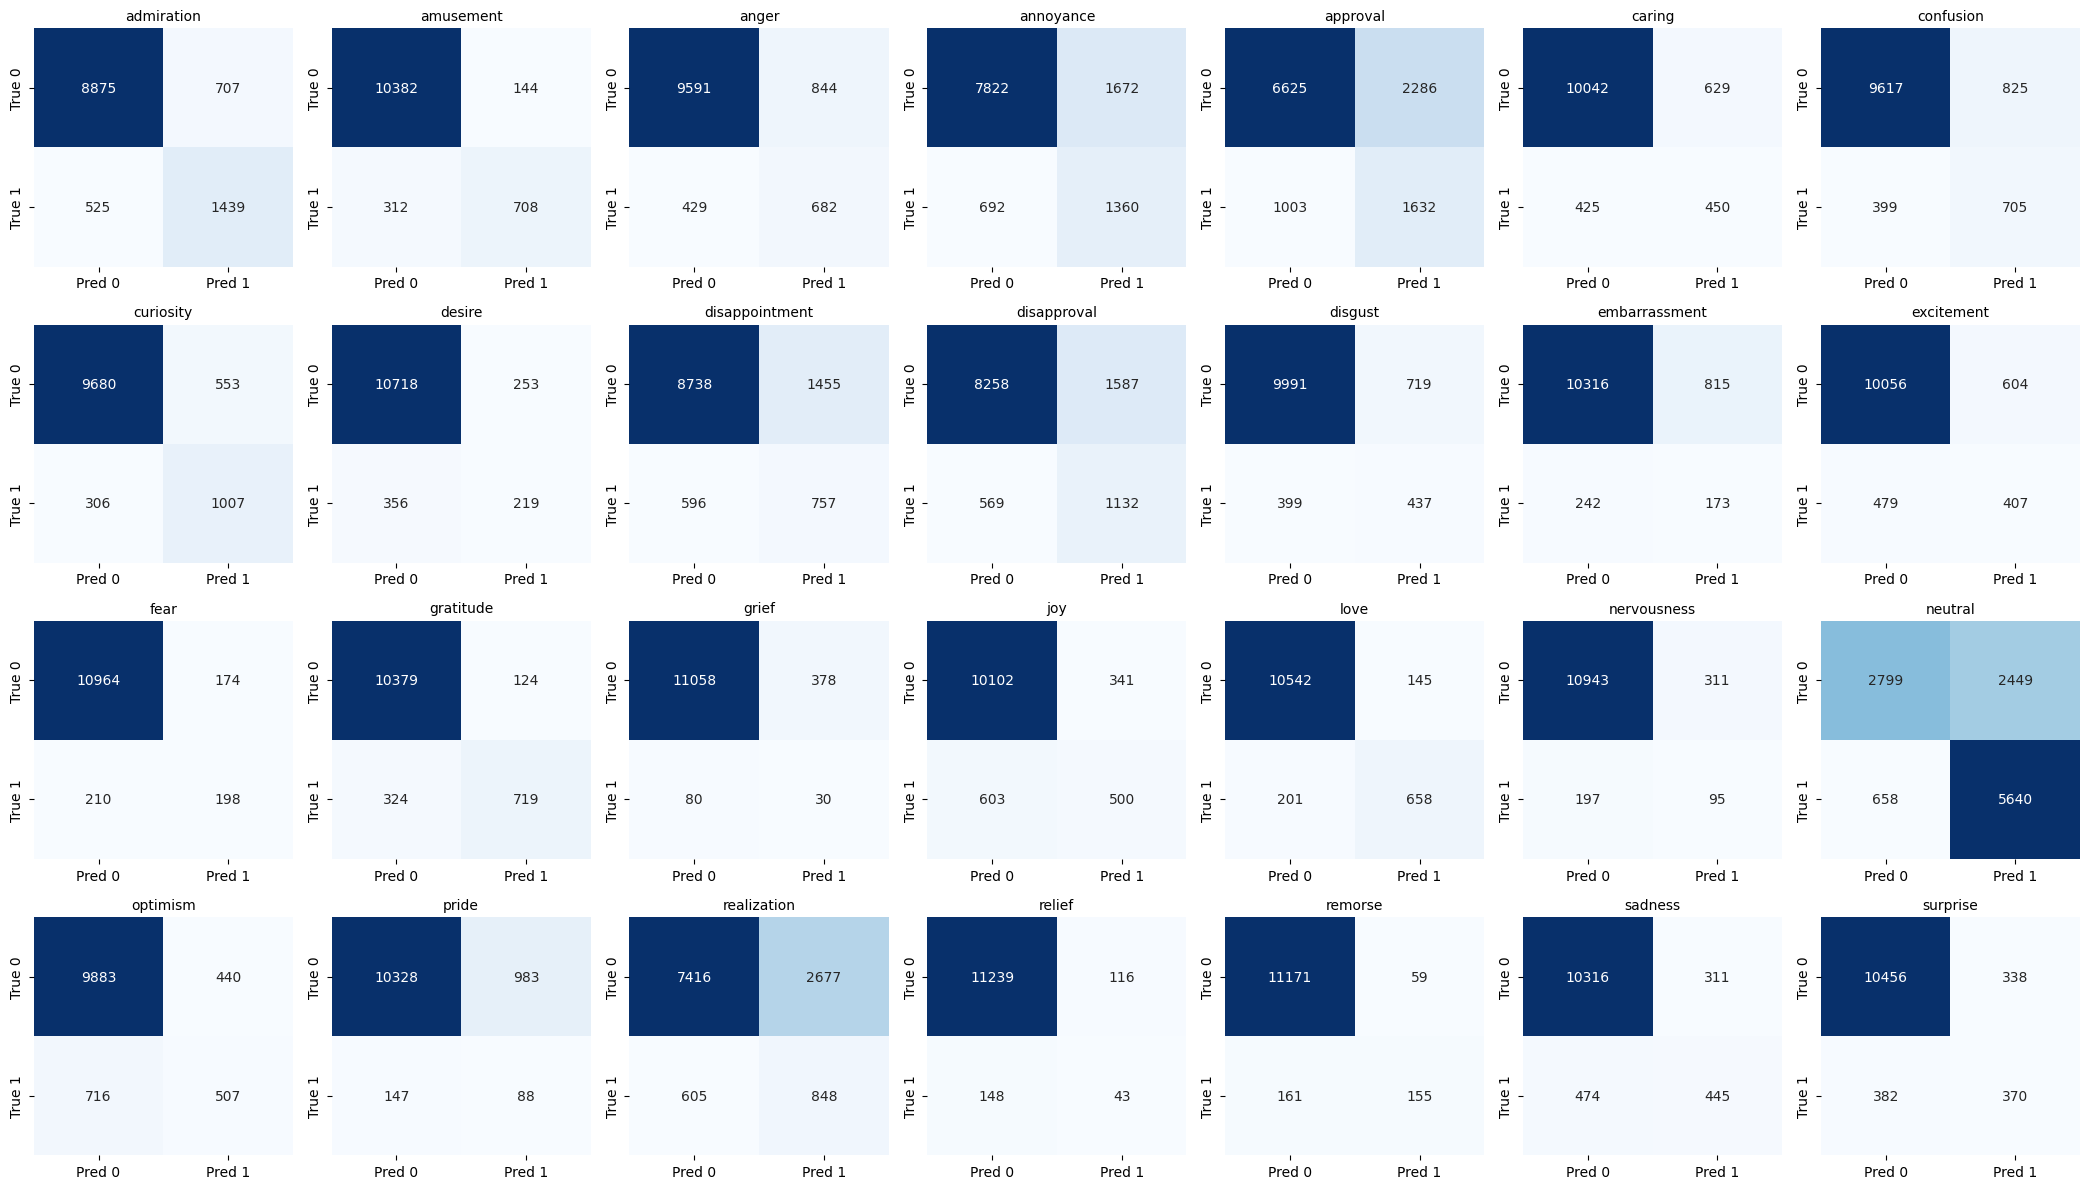

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Set up the grid
rows, cols = 4, 7
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()

for i in range(len(label_cols)):
    cm = confusion_matrix(labels[:, i], preds[:, i], labels=[0, 1])

    # Handle edge case: only one class present
    if cm.shape != (2, 2):
        full_cm = np.zeros((2, 2), dtype=int)
        full_cm[:cm.shape[0], :cm.shape[1]] = cm
        cm = full_cm

    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'], ax=ax)
    ax.set_title(label_cols[i], fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

for j in range(len(label_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/tmp/ipython-input-24-2703996680.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x='F1 Score', y='Label', palette='viridis')


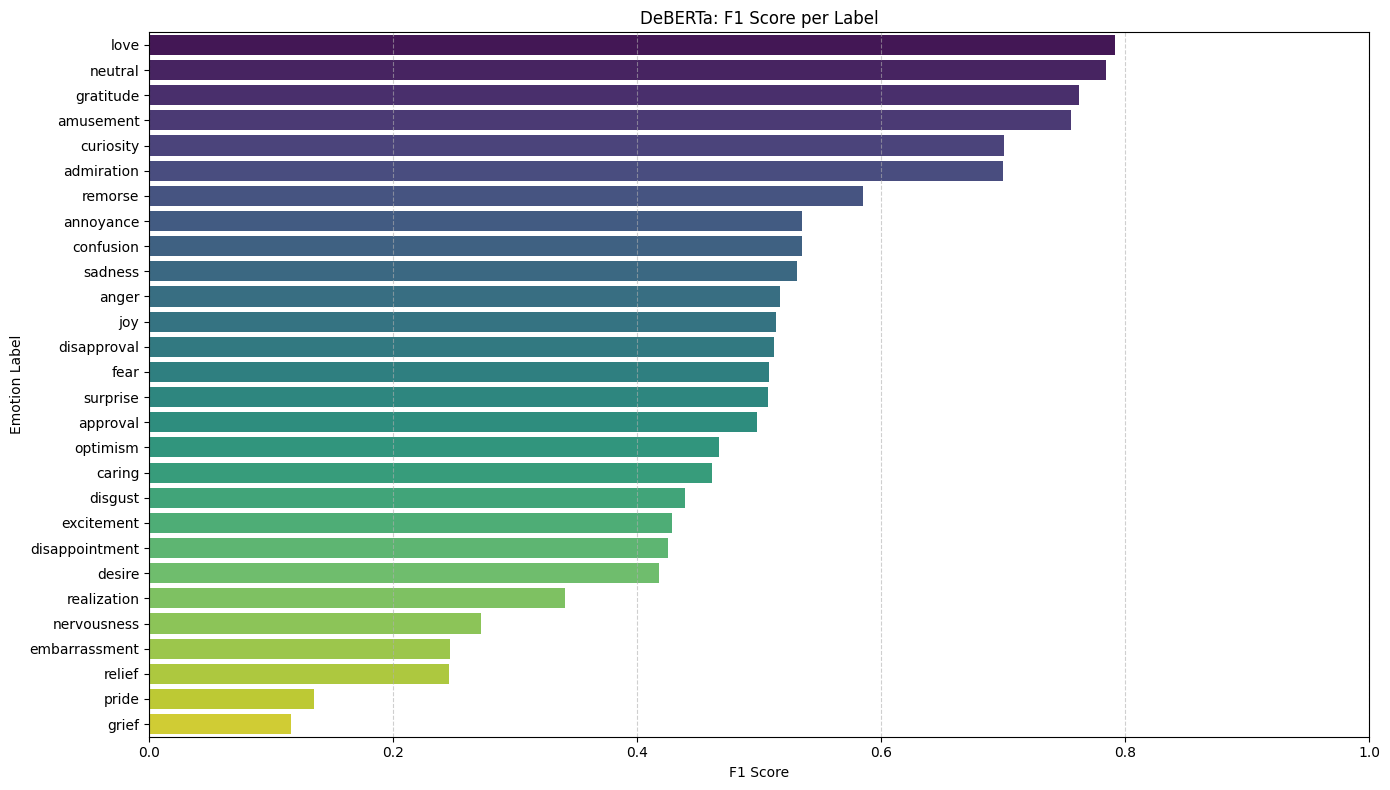

In [ ]:
# Sort by F1 score for better visualization
df_sorted = confusion_summary_df.sort_values(by='F1 Score', ascending=False)

# Set figure size
plt.figure(figsize=(14, 8))

# Plot F1 Score bar chart
sns.barplot(data=df_sorted, x='F1 Score', y='Label', palette='viridis')

plt.title('DeBERTa: F1 Score per Label')
plt.xlabel('F1 Score')
plt.ylabel('Emotion Label')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

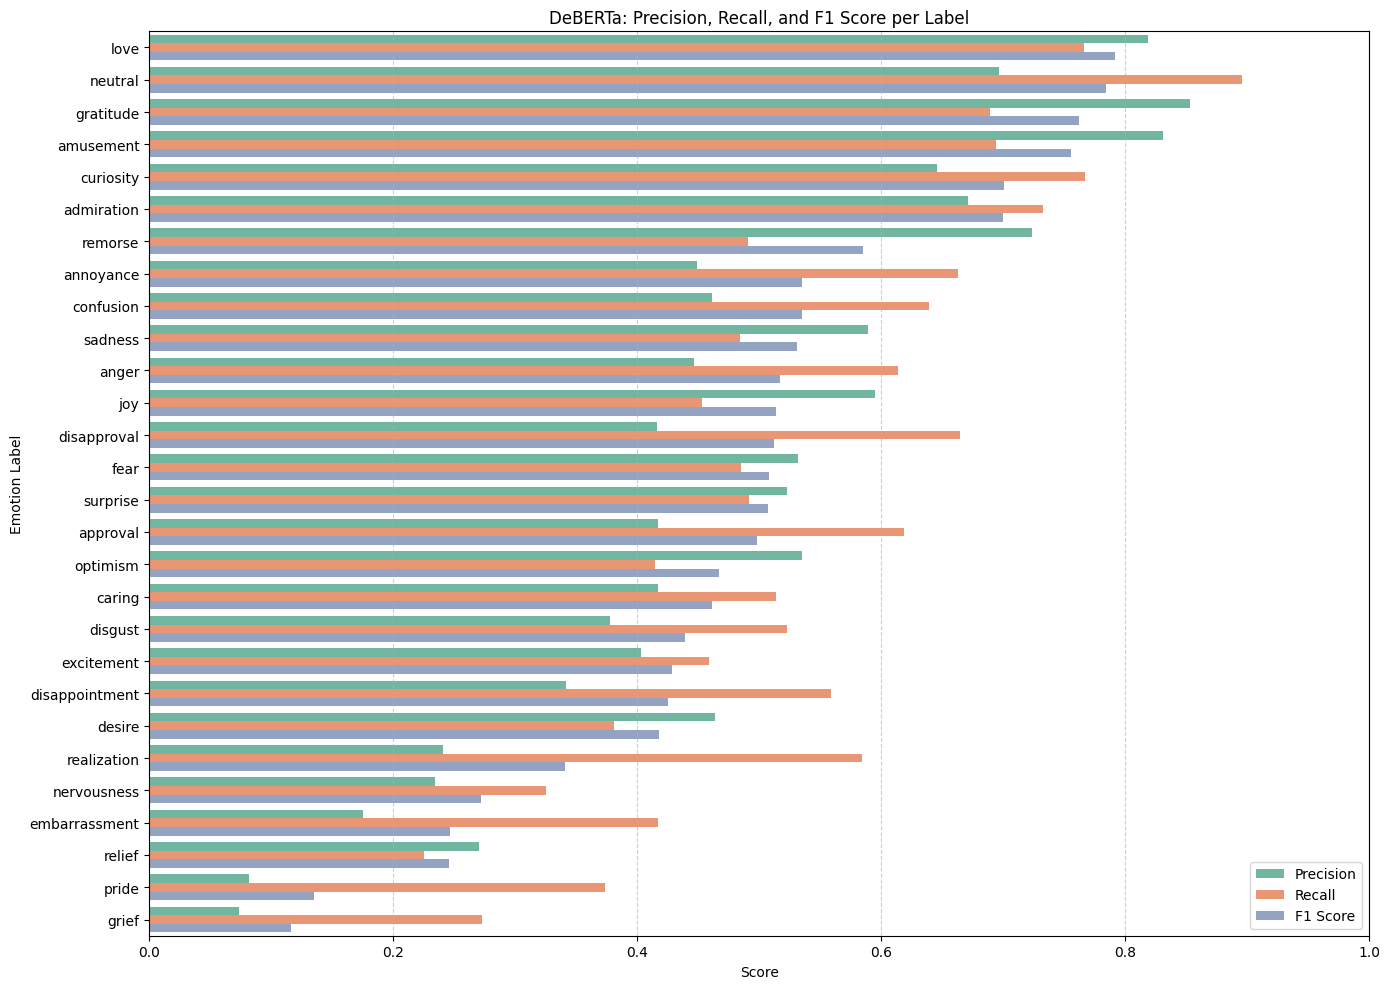

In [ ]:
# Melt the DataFrame to long format for Seaborn
metrics_df = df_sorted[['Label', 'Precision', 'Recall', 'F1 Score']].melt(id_vars='Label',
                                                                          var_name='Metric',
                                                                          value_name='Score')

plt.figure(figsize=(14, 10))
sns.barplot(data=metrics_df, x='Score', y='Label', hue='Metric', palette='Set2')

plt.title('DeBERTa: Precision, Recall, and F1 Score per Label')
plt.xlabel('Score')
plt.ylabel('Emotion Label')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Analyzing per-label precision, recall, and F1 scores in a multi-label emotion classification task provides valuable insights into how well the model is handling each individual emotion. By examining recall specifically, we can identify which emotions the model is frequently missing—these are cases where the emotion is present in the text but not predicted, leading to high false negatives. This is especially important in emotion detection tasks where overlooking subtle or rare emotions like fear or disgust can compromise the utility of the model. Precision, on the other hand, tells us how reliable the model's predictions are for each label—whether it is making accurate predictions without assigning emotions incorrectly. Viewing both metrics side by side helps us understand where the model is confident but possibly overpredicting (high precision, low recall), or where it is too cautious (low precision, high recall). Sorting and visualizing labels by recall allows us to quickly identify which emotions are best captured by the model and which require further attention, guiding efforts in data augmentation, threshold tuning, or model improvement strategies.

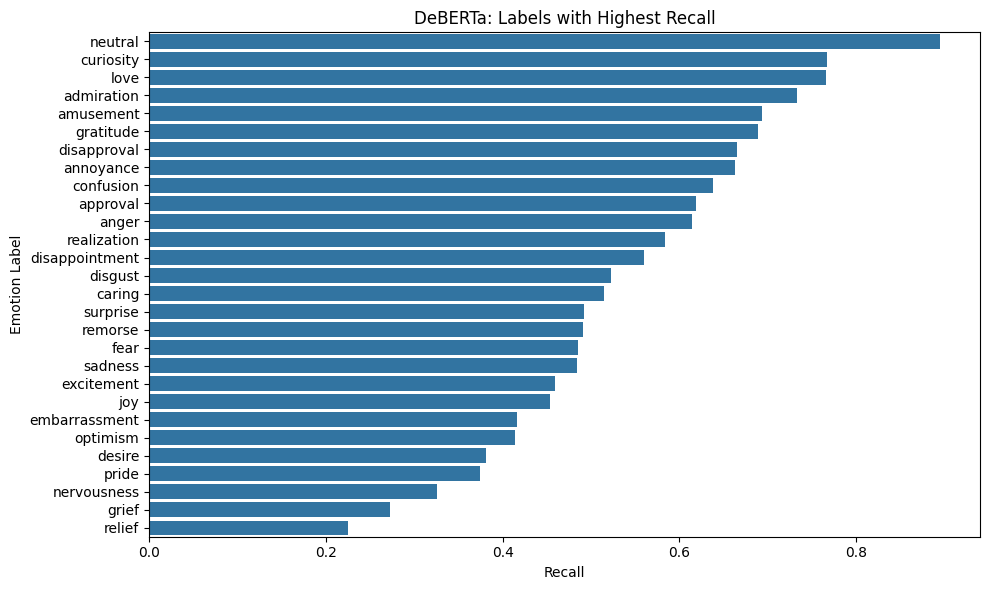

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1 for each label
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None)

# Put into a DataFrame
metric_df = pd.DataFrame({
    'Label': label_cols,
    'Precision': precision,
    'Recall': recall,
    'F1': f1
})

# Sort by Recall
top_recall = metric_df.sort_values(by='Recall', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Recall', y='Label', data=top_recall)
plt.title('DeBERTa: Labels with Highest Recall')
plt.xlabel('Recall')
plt.ylabel('Emotion Label')
plt.tight_layout()
plt.show()


This type of visualization is useful in multi-label classification problems because it reveals systematic misclassification patterns—particularly for labels with low recall, such as grief, embarrassment, and pride. In a multi-label setting, a model can predict several emotions per instance, so understanding which labels are predicted instead of a specific true label helps diagnose confusion between emotions. For example, if "grief" is often misclassified as "sadness" or "disappproval," this might indicate semantic overlap or insufficient representation in training data. These insights can guide data augmentation, targeted model improvements, or label grouping strategies to enhance model performance on under-recognized emotions.

/tmp/ipython-input-27-4191145651.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_preds.values, y=top_preds.index, ax=ax, palette='Blues_r')
/tmp/ipython-input-27-4191145651.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_preds.values, y=top_preds.index, ax=ax, palette='Blues_r')
/tmp/ipython-input-27-4191145651.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_preds.values, y=top_preds.index, ax=ax, palette='Blues_r')
/tmp/ipython-input-27-4191145651.py:27: FutureWarning: 

Passing `palette` without assigning `

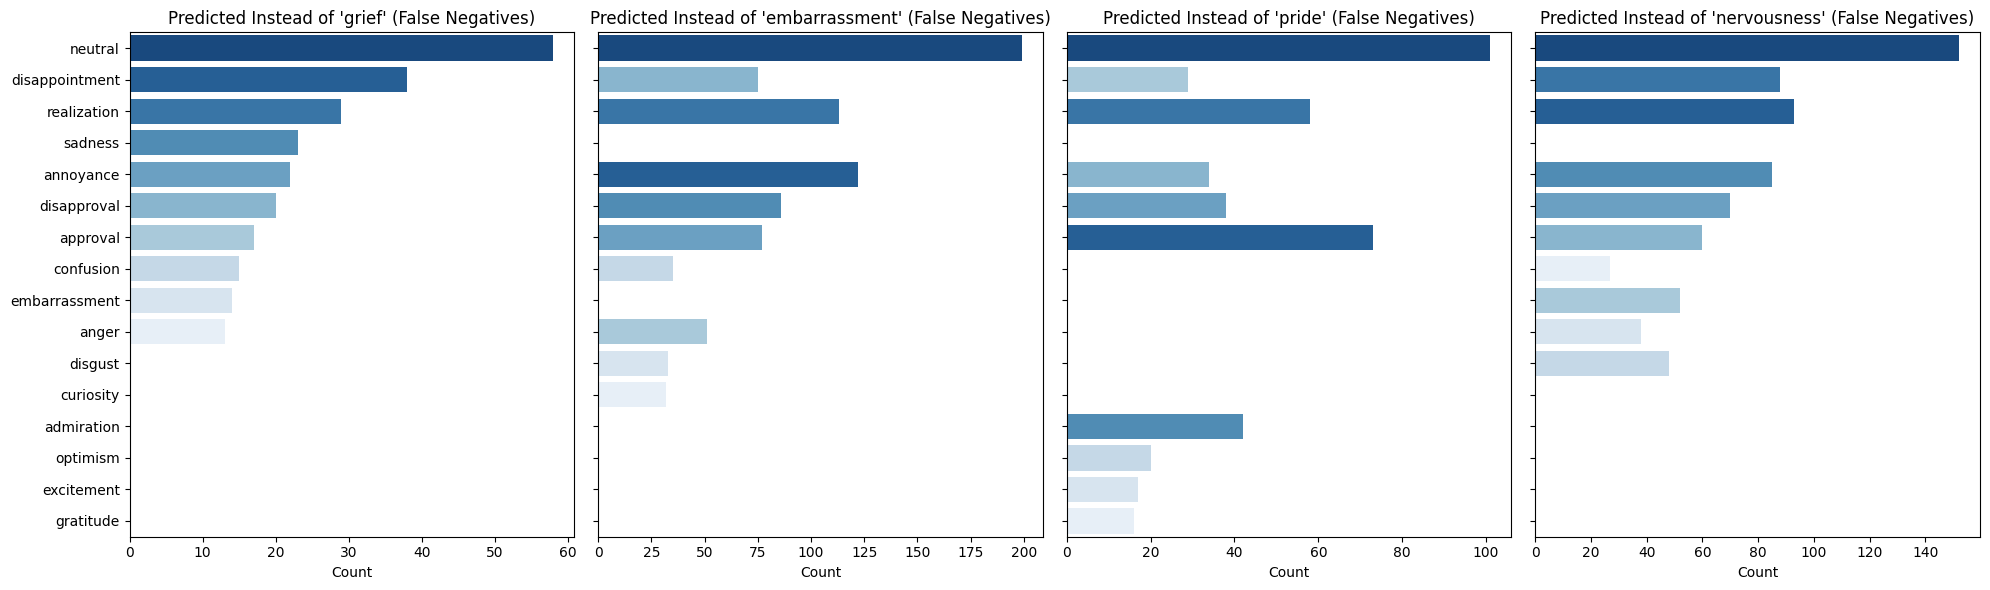

In [ ]:
# Labels to analyze
target_labels = ['grief', 'embarrassment', 'pride','nervousness']

# Convert to list if it's a Pandas Index
label_cols = list(label_cols)

# Store co-predicted label counts
co_predicted_counts = {}

for target in target_labels:
    idx = label_cols.index(target)

    fn_mask = (labels[:, idx] == 1) & (preds[:, idx] == 0)

    other_preds = preds[fn_mask]

    counts = np.sum(other_preds, axis=0)
    counts[idx] = 0
    co_predicted_counts[target] = pd.Series(counts, index=label_cols)


fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)

for ax, target in zip(axes, target_labels):
    top_preds = co_predicted_counts[target].sort_values(ascending=False)[:10]

    sns.barplot(x=top_preds.values, y=top_preds.index, ax=ax, palette='Blues_r')
    ax.set_title(f"Predicted Instead of '{target}' (False Negatives)")
    ax.set_xlabel("Count")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()


# N Binary Classification

Top 3 Labels  
* love
* neutral
* gratitude

Bottom 3 Labels
* pride
* embarrassment
* nervousness


In [14]:
## labels of interest
# import gc
from transformers import DebertaV2Model, DebertaV2PreTrainedModel
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
from torch import nn
import torch
MAX_SEQUENCE_LENGTH = 35
#target_labels = ['love', 'neutral', 'gratitude', 'pride', 'embarrassment', 'nervousness']
target_labels = ['love', 'gratitude', 'amusement', 'relief', 'pride', 'grief']

deberta_model_trainer = {}

model_checkpoint_name = "microsoft/deberta-v3-base"
tokenizer = DebertaV2Tokenizer.from_pretrained(model_checkpoint_name)

################################################################################
# Function to tokenize and extract binary label
def preprocess_binary_label(data, tokenizer, target_label):
    # Tokenize the 'text' data
    encoded = tokenizer.batch_encode_plus(
        data["text"],
        max_length=MAX_SEQUENCE_LENGTH,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
    )

    # Convert the binary label to integer type
    encoded["labels"] = [int(x) for x in data[target_label]]  # Convert to integer for cross_entropy
    return encoded

################################################################################
# Function for computing metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits has shape (batch_size, num_labels)
    preds = logits.argmax(axis=-1)   # shape (batch_size,), values in {0,1}

    return {
        "subset_accuracy": accuracy_score(labels, preds),
        "precision":        precision_score(labels, preds, average='binary', zero_division=0),
        "recall":           recall_score(labels, preds, average='binary', zero_division=0),
        "f1":               f1_score(labels, preds, average='binary', zero_division=0)
    }

################################################################################

# Train binary classifiers
for label in target_labels:

    deberta_model = DebertaV2ForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels=2, problem_type="single_label_classification")

    train_df = train_dataset.to_pandas()[['text', label]]
    val_df = val_dataset.to_pandas()[['text', label]]

    # Balance the training set (50% positive, 50% negative)
    train_pos = train_df[train_df[label] == 1]
    train_neg = train_df[train_df[label] == 0]

    if len(train_pos) < len(train_neg):
        train_neg = train_neg.sample(n=len(train_pos), random_state=42)
    else:
        train_pos = train_pos.sample(n=len(train_neg), random_state=42)

    train_balanced = pd.concat([train_pos, train_neg]).sample(frac=1, random_state=42)

    # Convert to HuggingFace Datasets
    train_balanced_dataset = Dataset.from_pandas(train_balanced)
    val_dataset_filtered = Dataset.from_pandas(val_df)

    # Tokenize datasets
    train_encoded = train_balanced_dataset.map(
        lambda x: preprocess_binary_label(x, tokenizer, label), batched=True
    )
    val_encoded = val_dataset_filtered.map(
        lambda x: preprocess_binary_label(x, tokenizer, label), batched=True
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"{label}_emotion_model",
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        num_train_epochs=2,
        eval_strategy="epoch",
        save_strategy="epoch",
        report_to="none",
        logging_strategy="epoch"
    )

    # Trainer
    trainer = Trainer(
        model=deberta_model,
        args=training_args,
        train_dataset=train_encoded,
        eval_dataset=val_encoded,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    print(f"\nTraining binary classifier for '{label}'...\n")
    trainer.train()
    deberta_model_trainer[label] = trainer

#    del trainer
#    del deberta_model
#    torch.cuda.empty_cache()
#    gc.collect()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Map:   0%|          | 0/5228 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-14-2516469578.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'love'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.470900,0.200082,0.958167,0.698881,0.786041,0.739903
2,0.338400,0.377284,0.909839,0.450268,0.864989,0.592244


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6412 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-14-2516469578.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'gratitude'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.488900,0.428984,0.883596,0.429691,0.897016,0.581047
2,0.378100,0.357612,0.891218,0.447610,0.892204,0.596141


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6166 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-14-2516469578.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'amusement'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.493500,0.336969,0.947601,0.705934,0.751161,0.727845
2,0.418900,0.406398,0.874069,0.413174,0.832869,0.552340


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1342 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-14-2516469578.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'relief'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.647300,1.051510,0.543305,0.037037,0.905830,0.071164
2,0.507000,0.770648,0.810064,0.077978,0.816143,0.142354


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1362 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-14-2516469578.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'pride'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.692700,0.654501,0.981725,0.000000,0.000000,0.000000
2,0.670000,0.951516,0.733674,0.043949,0.654028,0.082363


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/676 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-14-2516469578.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'grief'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.711300,0.855691,0.421791,0.015782,0.972727,0.031060
2,0.539400,0.918690,0.767712,0.033720,0.845455,0.064854


In [15]:
summary_metrics = []
error_rates = []

for label in target_labels:
    # Tokenize the test split for this label
    test_enc = test_dataset.map(
        lambda x: preprocess_binary_label(x, tokenizer, label),
        batched=True
    )

    # Predict
    logits, label_ids, _ = deberta_model_trainer[label].predict(test_enc)
    preds = logits.argmax(axis=-1)

    # Performance summary
    acc  = accuracy_score(label_ids, preds)
    prec = precision_score(label_ids, preds, zero_division=0)
    rec  = recall_score(label_ids, preds, zero_division=0)
    f1   = f1_score(label_ids, preds, zero_division=0)

    summary_metrics.append({
        'label':    label,
        'accuracy':  acc,
        'precision': prec,
        'recall':    rec,
        'f1_score':  f1
    })

    # Confusion matrix rates
    tn, fp, fn, tp = confusion_matrix(label_ids, preds).ravel()
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate

    error_rates.append({
        'label':                   label,
        'true_negative_rate':      tnr,
        'false_positive_rate':     fpr,
        'false_negative_rate':     fnr,
        'true_positive_rate':      tpr,
    })

# Build DataFrames
df_summary     = pd.DataFrame(summary_metrics)
df_error_rates = pd.DataFrame(error_rates)

# Display or save
print("=== Performance Summary ===")
print(df_summary.to_string(index=False))
print("\n=== Error Rates ===")
print(df_error_rates.to_string(index=False))


Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

=== Performance Summary ===
    label  accuracy  precision   recall  f1_score
     love  0.915036   0.462577 0.877765  0.605866
gratitude  0.890785   0.447292 0.886865  0.594664
amusement  0.876927   0.404204 0.829412  0.543527
   relief  0.815347   0.070004 0.827225  0.129085
    pride  0.729777   0.044234 0.595745  0.082353
    grief  0.755673   0.031779 0.836364  0.061231

=== Error Rates ===
    label  true_negative_rate  false_positive_rate  false_negative_rate  true_positive_rate
     love            0.918031             0.081969             0.122235            0.877765
gratitude            0.891174             0.108826             0.113135            0.886865
amusement            0.881531             0.118469             0.170588            0.829412
   relief            0.815148             0.184852             0.172775            0.827225
    pride            0.732561             0.267439             0.404255            0.595745
    grief            0.754897             0.24510

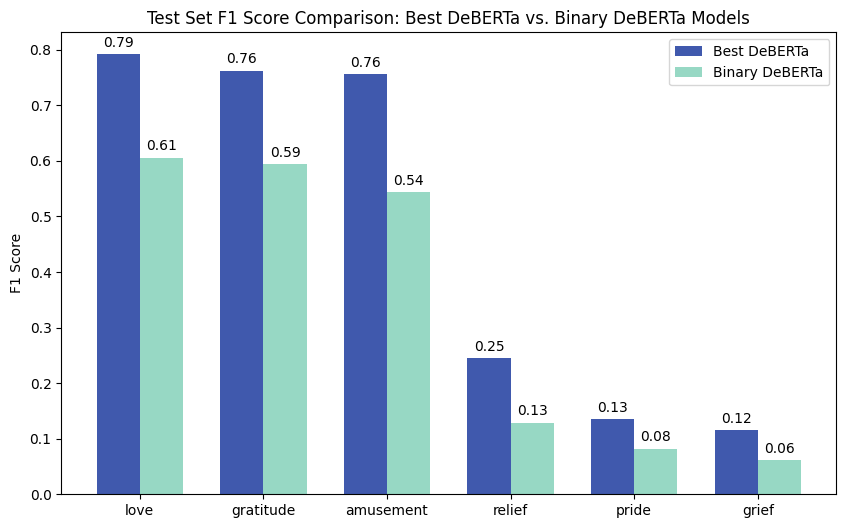

In [19]:

target_labels = ['love', 'gratitude', 'amusement', 'relief', 'pride', 'grief']
# Best deBERTa model F1 results from test set: weights, thresholds
deberta_best_model = [ 0.791817, 0.762460, 0.756410, 0.245714, 0.134763, 0.115830]
# deBERTa binary results from test set
binary_deberta = [0.605866, 0.594664, 0.543527, 0.129085, 0.082353, 0.061231]

# creating bar graph
x= np.arange(len(target_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, deberta_best_model, width, label='Best DeBERTa',color='#4059AD')
rects2 = ax.bar(x + width/2, binary_deberta, width, label='Binary DeBERTa', color='#97D8C4')

ax.set_ylabel('F1 Score')
ax.set_title('Test Set F1 Score Comparison: Best DeBERTa vs. Binary DeBERTa Models')
ax.set_xticks(x)
ax.set_xticklabels(target_labels)
ax.legend()

ax.bar_label(rects1, fmt='%.2f', padding=3)
ax.bar_label(rects2, fmt='%.2f', padding=3)

plt.show()

